<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
#Загрузим необходимые библиотеки
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

In [2]:
#Загрузим данные
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    print('Ошибка. Проверьте правильность пути к данным')
data.sort_index(inplace=True)
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [5]:
#Посмортим на процент пропусков
pd.DataFrame(round((data.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
num_orders,0.000000


In [6]:
#Выполним ресемплирование данных по одному часу
data = data.resample('1H').sum()

**Вывод:** Данные загружены, пропусков нет. Проведено ресемплирование по одному часу. Данные готовы к анализу и обучению моделей.

## Анализ

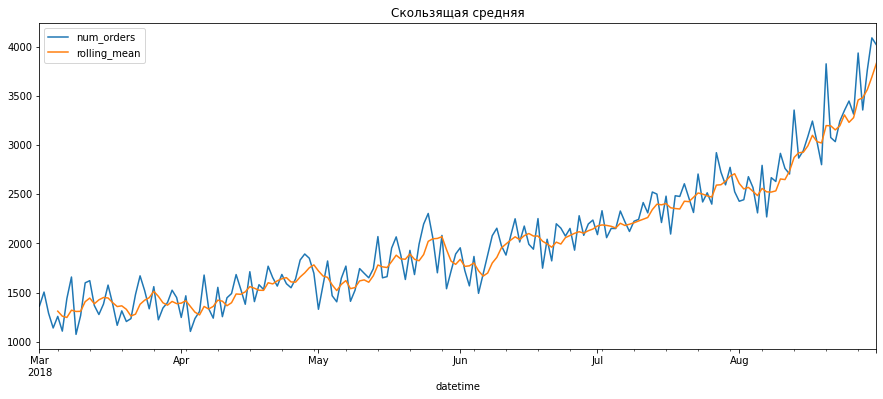

In [7]:
data_day = data.resample('1D').sum()
data_day['rolling_mean'] = data_day['num_orders'].rolling(5).mean()
data_day.plot(figsize=(15,6))
plt.title('Скользящая средняя')
plt.show()

In [8]:
decomposed = seasonal_decompose(data)

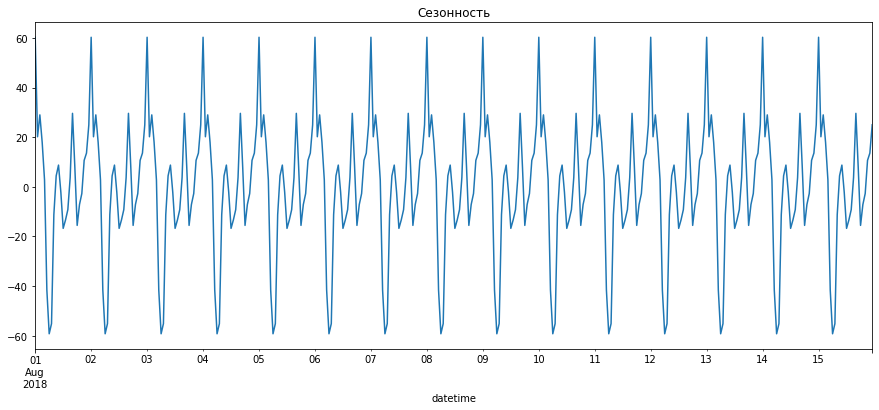

In [9]:
decomposed.seasonal['2018-08-01':'2018-08-15'].plot(ax=plt.gca(), title='Сезонность', figsize=(15,6))
plt.show()

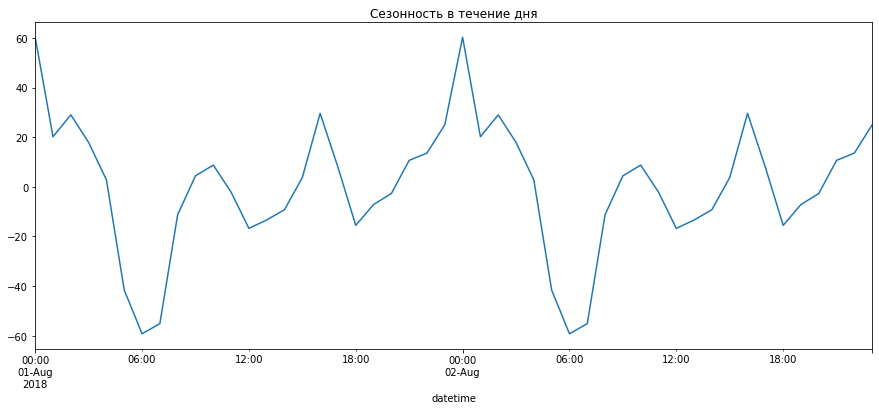

In [10]:
decomposed.seasonal['2018-08-01':'2018-08-02'].plot(ax=plt.gca(), title='Сезонность в течение дня', figsize=(15,6))
plt.show()

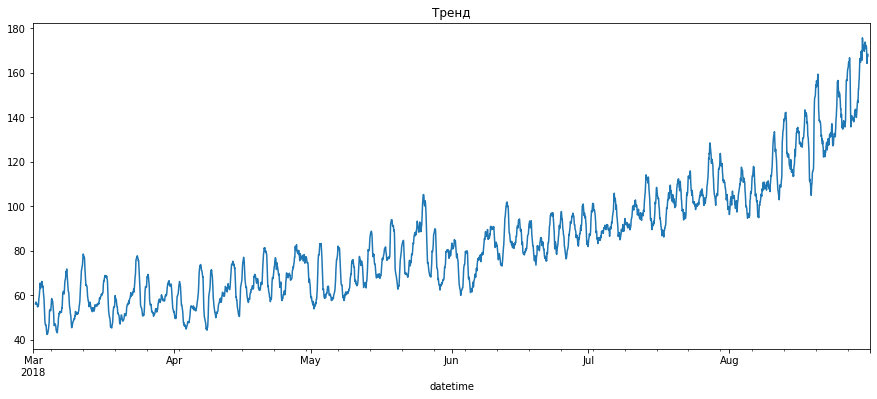

In [11]:
decomposed.trend.plot(ax=plt.gca(), title='Тренд', figsize=(15,6))
plt.show()

**Вывод:** Количество заказов растёт с каждым месяцем. Это видно на графиках скользящей средней и тренда. В течение дня количество заказов распределено неравномерно. Оно растёт вечером и достигает пика в районе 12 часов ночи. Потом снижается и достигает минимальных значений в районе 6 часов утра.

## Обучение

Подготовим признаки

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

Обучим модель Линейной регрессии. Подберем для модели лучшие значения lag и size.

In [13]:
rmse_ = 10**4
best_lag = 0
est_rolling_size = 0
for lag in range(1, 50):
    for size in range(1,50):
        data = make_features(data, lag, size)
        train, test = train_test_split(data, shuffle=False, test_size=0.1)
        train = train.dropna()

        target_train_lr = train['num_orders']
        features_train_lr = train.drop(['num_orders'], axis=1)
        target_test_lr = test['num_orders']
        features_test_lr = test.drop(['num_orders'], axis=1)
        
        lr = LinearRegression()
        lr.fit(features_train_lr, target_train_lr)
        
        predictions_train_lr = lr.predict(features_train_lr)
        rmse = mean_squared_error(target_train_lr, predictions_train_lr)**0.5
        if rmse < rmse_:
            rmse_ = rmse
            best_lag = lag
            best_rolling_size = size

print('RMSE линейной регрессии на тренировочной выборке:', rmse_)
print('Лучшие параметры:', 'max_lag:', best_lag, 'rolling_mean_size:', best_rolling_size)

RMSE линейной регрессии на тренировочной выборке: 23.431563126633225
Лучшие параметры: max_lag: 49 rolling_mean_size: 22


Обучим модель LGBMRegressor с лучшими параметрами.

In [14]:
data = make_features(data, 49, 22)

train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

target_train_lgbm = train['num_orders']
features_train_lgbm = train.drop(['num_orders'], axis=1)
target_test_lgbm = test['num_orders']
features_test_lgbm = test.drop(['num_orders'], axis=1)

lgbm = LGBMRegressor()
lgbm.fit(features_train_lgbm, target_train_lgbm)

predictions_train_lgbm = lgbm.predict(features_train_lgbm)
rmse = mean_squared_error(target_train_lgbm, predictions_train_lgbm)**0.5
       
print('RMSE LightGBM модели на тренировочной выборке:', rmse)

RMSE LightGBM модели на тренировочной выборке: 10.790549755542035


In [15]:
train.head()

,num_orders,day,dayofweek,hour,lag_1,rolling_mean,lag_2,lag_3,lag_4,lag_5,...,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 01:00:00,108,3,5,1,163.0,62.909091,72.0,119.0,101.0,93.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-03 02:00:00,25,3,5,2,108.0,64.909091,163.0,72.0,119.0,101.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-03 03:00:00,64,3,5,3,25.0,65.136364,108.0,163.0,72.0,119.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0
2018-03-03 04:00:00,44,3,5,4,64.0,67.545455,25.0,108.0,163.0,72.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0
2018-03-03 05:00:00,15,3,5,5,44.0,69.045455,64.0,25.0,108.0,163.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0


Обучим модель CatBoostRegressor с лучшими параметрами.

In [16]:
data = make_features(data, 49, 22)

train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

target_train_cbr = train['num_orders']
features_train_cbr = train.drop(['num_orders'], axis=1)
target_test_cbr = test['num_orders']
features_test_cbr = test.drop(['num_orders'], axis=1)

cat = CatBoostRegressor()
cat.fit(features_train_cbr, target_train_cbr)

predictions_train_cbr = cat.predict(features_train_cbr)
rmse = mean_squared_error(target_train_cbr, predictions_train_cbr)**0.5
       
print('RMSE CatBoostRegressor модели на тренировочной выборке:', rmse)

Learning rate set to 0.050817
0:	learn: 37.6855580	total: 64.7ms	remaining: 1m 4s
1:	learn: 36.7268754	total: 77.8ms	remaining: 38.8s
2:	learn: 35.8395701	total: 90.6ms	remaining: 30.1s
3:	learn: 35.0387527	total: 105ms	remaining: 26.1s
4:	learn: 34.3292071	total: 123ms	remaining: 24.5s
5:	learn: 33.5645363	total: 140ms	remaining: 23.2s
6:	learn: 32.8921787	total: 158ms	remaining: 22.4s
7:	learn: 32.2867686	total: 172ms	remaining: 21.3s
8:	learn: 31.7277823	total: 186ms	remaining: 20.4s
9:	learn: 31.1466210	total: 206ms	remaining: 20.4s
10:	learn: 30.6490913	total: 228ms	remaining: 20.5s
11:	learn: 30.1617303	total: 253ms	remaining: 20.8s
12:	learn: 29.7091723	total: 275ms	remaining: 20.9s
13:	learn: 29.2543893	total: 297ms	remaining: 20.9s
14:	learn: 28.8465731	total: 319ms	remaining: 20.9s
15:	learn: 28.4698416	total: 341ms	remaining: 21s
16:	learn: 28.1055496	total: 363ms	remaining: 21s
17:	learn: 27.7900733	total: 385ms	remaining: 21s
18:	learn: 27.4574441	total: 408ms	remaining: 2

Вывод: На тренировочной выборке лучшее значение RMSE показывает модель CatBoostRegressor. Немного хуже значения у модели LightGBM. Линейная регрессия показывает значение RMSE гораздо хуже, чем у других моделей. 

## Тестирование

Проверим RMSE моделей на тестовой выборке:

Модель Линейной регрессии

In [17]:
predictions_test_lr = lr.predict(features_test_lr)
rmse = mean_squared_error(target_test_lr, predictions_test_lr)**0.5
print('RMSE модели линейной регрессии на тестовой выборке:', rmse)

RMSE модели линейной регрессии на тестовой выборке: 41.84127550172381


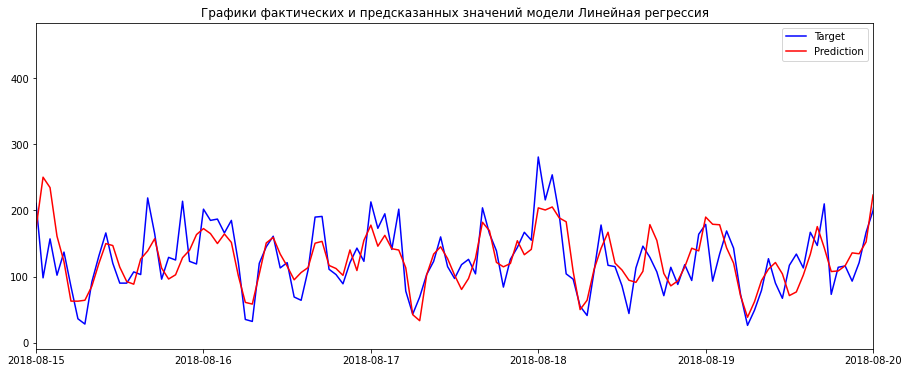

In [41]:
left = datetime.date(2018, 8, 15)
right = datetime.date(2018, 8, 20)
plt.figure(figsize=(15,6))
plt.plot(target_test_lr.index, 
         target_test_lr, 
         'b-',
         target_test_lr.index, 
         predictions_test_lr,
         'r-')
plt.gca().set_xbound(left, right)
plt.title('Графики фактических и предсказанных значений модели Линейная регрессия')
plt.legend(['Target', 'Prediction'])
plt.show()

Модель LightGBM

In [31]:
predictions_test_lgbm = lgbm.predict(features_test_lgbm)
rmse = mean_squared_error(target_test_lgbm, predictions_test_lgbm)**0.5
print('RMSE модели LightGBM на тестовой выборке:', rmse)

RMSE модели LightGBM на тестовой выборке: 39.43436078640277


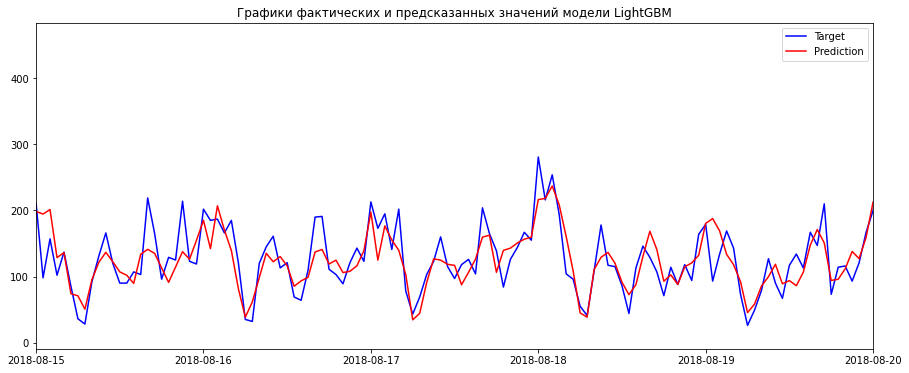

In [45]:
left = datetime.date(2018, 8, 15)
right = datetime.date(2018, 8, 20)
plt.figure(figsize=(15,6))
plt.plot(target_test_lgbm.index, 
         target_test_lgbm, 
         'b-', 
         target_test_lgbm.index, 
         predictions_test_lgbm,
         'r-')
plt.gca().set_xbound(left, right)
plt.title('Графики фактических и предсказанных значений модели LightGBM')
plt.legend(['Target', 'Prediction'])
plt.show()

Модель CatBoostRegressor

In [33]:
predictions_test_cbr = cat.predict(features_test_cbr)
rmse = mean_squared_error(target_test_cbr, predictions_test_cbr)**0.5
print('RMSE модели CatBoostRegressor на тестовой выборке:', rmse)

RMSE модели CatBoostRegressor на тестовой выборке: 39.912378105846415


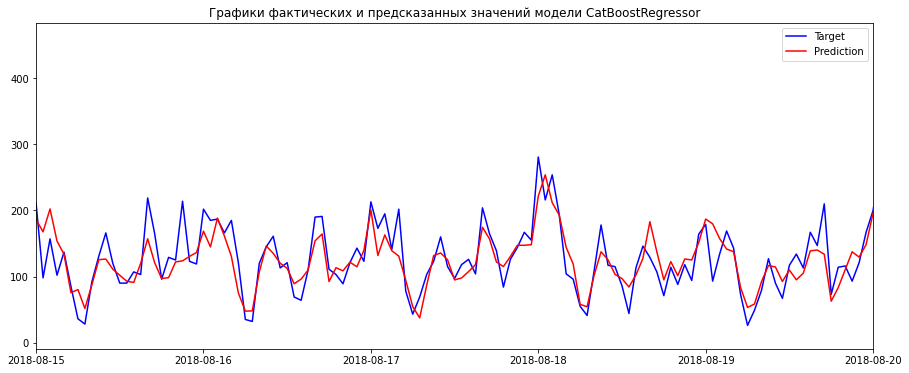

In [46]:
left = datetime.date(2018, 8, 15)
right = datetime.date(2018, 8, 20)
plt.figure(figsize=(15,6))
plt.plot(target_test_cbr.index, 
         target_test_cbr, 
         'b-', 
         target_test_cbr.index, 
         predictions_test_cbr,
         'r-')
plt.gca().set_xbound(left, right)
plt.title('Графики фактических и предсказанных значений модели CatBoostRegressor')
plt.legend(['Target', 'Prediction'])
plt.show()

Вывод: На тестовой выборке все три модели показывают близкие значения RMSE. У линейной регрессии уже нет такого большого отставания от других моделей. Все модели уложились в необходимое для выполнения задания значение PSME < 48.